In [1]:
import os
import typing
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib

from typing import Tuple

sns.set_theme()
plt.figure(figsize = (22,16))

<Figure size 2200x1600 with 0 Axes>

<Figure size 2200x1600 with 0 Axes>

In [2]:
# file management to set up data directory
current_folder = globals()['_dh'][0]
project_folder = "/".join(str(current_folder).split("/")[:-1])
data_directory = os.path.join(project_folder, "data")

In [3]:
os.listdir(data_directory)

['sbab_mortgage_pricing_11_04_23.csv',
 'ica_mortgage_pricing_20_04_23.csv',
 'sbab_mortgage_pricing_10_04_23.csv',
 '.gitkeep',
 'ica_mortgage_pricing_30_03_23.csv',
 'sbab_mortgage_pricing_13_04_23.csv',
 'sbab_mortgage_pricing_20_04_23.csv',
 'sbab_mortgage_pricing_06_04_23.csv']

In [4]:
# set up data import
filepath = os.path.join(data_directory, "sbab_mortgage_pricing_20_04_23.csv")
df = pd.read_csv(filepath, index_col=0)

In [5]:
# standardise and strip superflous columns
superflous_cols = ["provider", "effektivrantesats", "loptidtext"]
relevant_cols = [c for c in df.columns if c not in superflous_cols]

df = df[relevant_cols]
df.columns = [c.lower().strip() for c in df.columns]

clean_columns_names = {
    "rantesats": "interest_rate",
    "rantebindningstid": "period",
    "loan_amount": "loan_volume",
}

df = df.rename(columns=clean_columns_names)
df.head()

,loptidtext,interest_rate,period,effektivrantesats,loan_volume,asset_value
0,2023-07-24,4.17,3,0.0,50000,50000
1,2024-04-24,4.92,12,0.0,50000,50000
2,2025-05-19,4.91,24,0.0,50000,50000
3,2026-05-19,4.73,36,0.0,50000,50000
4,2027-05-19,4.65,48,0.0,50000,50000


In [6]:
# adding LTV ratios and dropping rows with LTVs > 1
df["ltv"] = df.loan_volume / df.asset_value
df = df.loc[df["ltv"] <= 1]

In [7]:
# subset into different maturity periods ltv > 0.5
mask = (df.period == 3) & (df.ltv >= 0.5)
three_month_df = df.loc[mask].drop(["period", "asset_value"], axis=1)

# adding discount (ambigious, but inferred through the max rate)
three_month_df["discount"] = three_month_df["interest_rate"] - three_month_df["interest_rate"].max()

In [8]:
# we should get different interest rates different tuples of LTV,Volume, i.e. 2-dimensional pricing.
three_month_df.interest_rate.value_counts().shape 

(29,)

In [9]:
sorted([round(v, 2) for v in list(three_month_df["discount"].unique())])

[-0.45,
 -0.43,
 -0.4,
 -0.37,
 -0.35,
 -0.32,
 -0.3,
 -0.29,
 -0.27,
 -0.25,
 -0.24,
 -0.23,
 -0.22,
 -0.2,
 -0.19,
 -0.18,
 -0.17,
 -0.15,
 -0.14,
 -0.13,
 -0.12,
 -0.11,
 -0.1,
 -0.08,
 -0.07,
 -0.06,
 -0.05,
 -0.03,
 0.0]

In [10]:
three_month_df[["interest_rate", "loan_volume", "ltv"]]

,interest_rate,loan_volume,ltv
0,4.17,50000,1.000000
8,4.17,50000,0.500000
1608,4.17,100000,1.000000
1616,4.17,100000,0.666667
1624,4.17,100000,0.500000
...,...,...,...
316784,4.17,9900000,0.994975
316792,4.17,9900000,0.990000
318384,4.17,9950000,1.000000
318392,4.17,9950000,0.995000


### Using existing bins

Ideally we'd like to automatically detect what bins are used, both in terms of LTV and loan volume. It is clear the the 2-dimensional attribute do affect interest rate (price), so we need to know exactly how large the bins are. Prior these bins were found manually via graphical inspection. Some automated version would be prefereble.

In [11]:
three_month_df.discount.value_counts()

 0.00    3250
-0.45    1741
-0.40    1416
-0.43     920
-0.12     717
-0.35     333
-0.37     330
-0.30     172
-0.25     172
-0.20     171
-0.32     171
-0.15     156
-0.10     137
-0.27     117
-0.05      98
-0.22      76
-0.18      41
-0.13      40
-0.17      23
-0.14      22
-0.08      20
-0.11      18
-0.29      14
-0.23      12
-0.06      11
-0.03      10
-0.24       4
-0.19       4
-0.07       4
Name: discount, dtype: int64

In [12]:
# given in millions
loan_volume_in_millions_bins = [
    (0, 0.5),
    (0.5, 0.7),
    (0.7, 0.8),
    (0.8, 0.9),
    (0.9, 1.0),
    (1.0, 1.5),
    (1.5, 2.0),
    (2.0, 2.5),
    (2.5, 3.0),
    (3.5, 4.0),
    (4.0, 4.5),
    (4.5, 5.0),
    (5.0, 7.0),
    (7.0, float("inf"))
]
loan_volume_bins = [(start * 1_000_000, stop * 1_000_000) for start, stop in loan_volume_in_millions_bins]

ltv_bins = [
    (0, 0.5),
    (0.5, 0.6),
    (0.6, 0.65),
    (0.65, 0.7),
    (0.7, 0.75),
    (0.75, 0.76),
    (0.76, 0.77),
    (0.78, 0.79),
    (0.79, 0.8),
    (0.8, 0.85),
    (0.85, 1.0),
]

In [13]:
three_month_df

,loptidtext,interest_rate,effektivrantesats,loan_volume,ltv,discount
0,2023-07-24,4.17,0.0,50000,1.000000,0.0
8,2023-07-24,4.17,0.0,50000,0.500000,0.0
1608,2023-07-24,4.17,0.0,100000,1.000000,0.0
1616,2023-07-24,4.17,0.0,100000,0.666667,0.0
1624,2023-07-24,4.17,0.0,100000,0.500000,0.0
...,...,...,...,...,...,...
316784,2023-07-24,4.17,0.0,9900000,0.994975,0.0
316792,2023-07-24,4.17,0.0,9900000,0.990000,0.0
318384,2023-07-24,4.17,0.0,9950000,1.000000,0.0
318392,2023-07-24,4.17,0.0,9950000,0.995000,0.0


In [14]:
# set up pricing surface
rows = ["-".join([str(low), str(high)]) for low, high in loan_volume_bins]
cols = ["-".join([str(low),str(high)]) for low, high in ltv_bins]
three_month_discount_df = pd.DataFrame(index=rows, columns=cols)

In [20]:
three_month_df

,loptidtext,interest_rate,effektivrantesats,loan_volume,ltv,discount
0,2023-07-24,4.17,0.0,50000,1.000000,0.0
8,2023-07-24,4.17,0.0,50000,0.500000,0.0
1608,2023-07-24,4.17,0.0,100000,1.000000,0.0
1616,2023-07-24,4.17,0.0,100000,0.666667,0.0
1624,2023-07-24,4.17,0.0,100000,0.500000,0.0
...,...,...,...,...,...,...
316784,2023-07-24,4.17,0.0,9900000,0.994975,0.0
316792,2023-07-24,4.17,0.0,9900000,0.990000,0.0
318384,2023-07-24,4.17,0.0,9950000,1.000000,0.0
318392,2023-07-24,4.17,0.0,9950000,0.995000,0.0


In [30]:
# Fill discount matrix for the selected bins and visualise as heatmap (pricing surface)
i, j = three_month_discount_df.shape


def parse_bin(param_bin: str) -> Tuple[float, float]:
    return tuple([float(v) for v in param_bin.split("-")])


for i in range(i):
    for j in range(j):

        ltv_start, ltv_stop = parse_bin(cols[j])
        loan_start, loan_stop = parse_bin(rows[i])

        ltv_mask1 = three_month_df.ltv >= ltv_start
        ltv_mask2 = three_month_df.ltv < ltv_stop
        vol_mask1 = three_month_df.loan_volume >= loan_start
        vol_mask2 = three_month_df.loan_volume < loan_stop
        
        mask = (ltv_mask1 & ltv_mask2 & vol_mask1 & vol_mask2)
        discounts_in_bin = three_month_df.loc[mask]["discount"]
            
        three_month_discount_df.at[rows[i], cols[j]] = three_month_df.loc[mask]["discount"]

multiple discounts for bin detected
Series([], Name: discount, dtype: float64)
multiple discounts for bin detected
Series([], Name: discount, dtype: float64)
multiple discounts for bin detected
Series([], Name: discount, dtype: float64)
multiple discounts for bin detected
Series([], Name: discount, dtype: float64)
multiple discounts for bin detected
Series([], Name: discount, dtype: float64)
multiple discounts for bin detected
14528   -0.06
14536   -0.06
14544   -0.06
14552   -0.06
16144   -0.06
16152   -0.06
16160   -0.06
16168   -0.06
17760   -0.12
17768   -0.12
17776   -0.12
17784   -0.12
19368   -0.12
19376   -0.12
19384   -0.12
19392   -0.12
19400   -0.12
Name: discount, dtype: float64
multiple discounts for bin detected
14520   -0.03
16128   -0.03
16136   -0.03
17744   -0.06
17752   -0.12
19360   -0.06
Name: discount, dtype: float64
multiple discounts for bin detected
14512    0.00
16120    0.00
17736   -0.03
19344   -0.03
19352   -0.06
Name: discount, dtype: float64
multiple dis

In [34]:
three_month_discount_df

,0-0.5,0.5-0.6,0.6-0.65,0.65-0.7,0.7-0.75,0.75-0.76,0.76-0.77,0.78-0.79,0.79-0.8,0.8-0.85,0.85-1.0
0-500000.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0
500000.0-700000.0,NaN,-0.091765,-0.055,-0.024,0.0,0.0,0.0,0.0,NaN,0.0,NaN
700000.0-800000.0,NaN,-0.18,-0.135,-0.07,-0.043333,-0.03,NaN,0.0,NaN,NaN,NaN
800000.0-900000.0,NaN,-0.23,-0.18,-0.13,-0.08,NaN,-0.03,NaN,NaN,NaN,NaN
900000.0-1000000.0,NaN,-0.29,-0.25,-0.19,-0.14,-0.14,-0.11,NaN,NaN,NaN,NaN
1000000.0-1500000.0,NaN,-0.35,-0.304545,-0.251923,-0.204348,-0.185,NaN,NaN,NaN,NaN,NaN
1500000.0-2000000.0,NaN,-0.37,-0.324348,-0.271316,-0.221613,NaN,NaN,NaN,NaN,NaN,NaN
2000000.0-2500000.0,NaN,-0.4,-0.371552,-0.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2500000.0-3000000.0,NaN,-0.4,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3500000.0-4000000.0,NaN,-0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: >

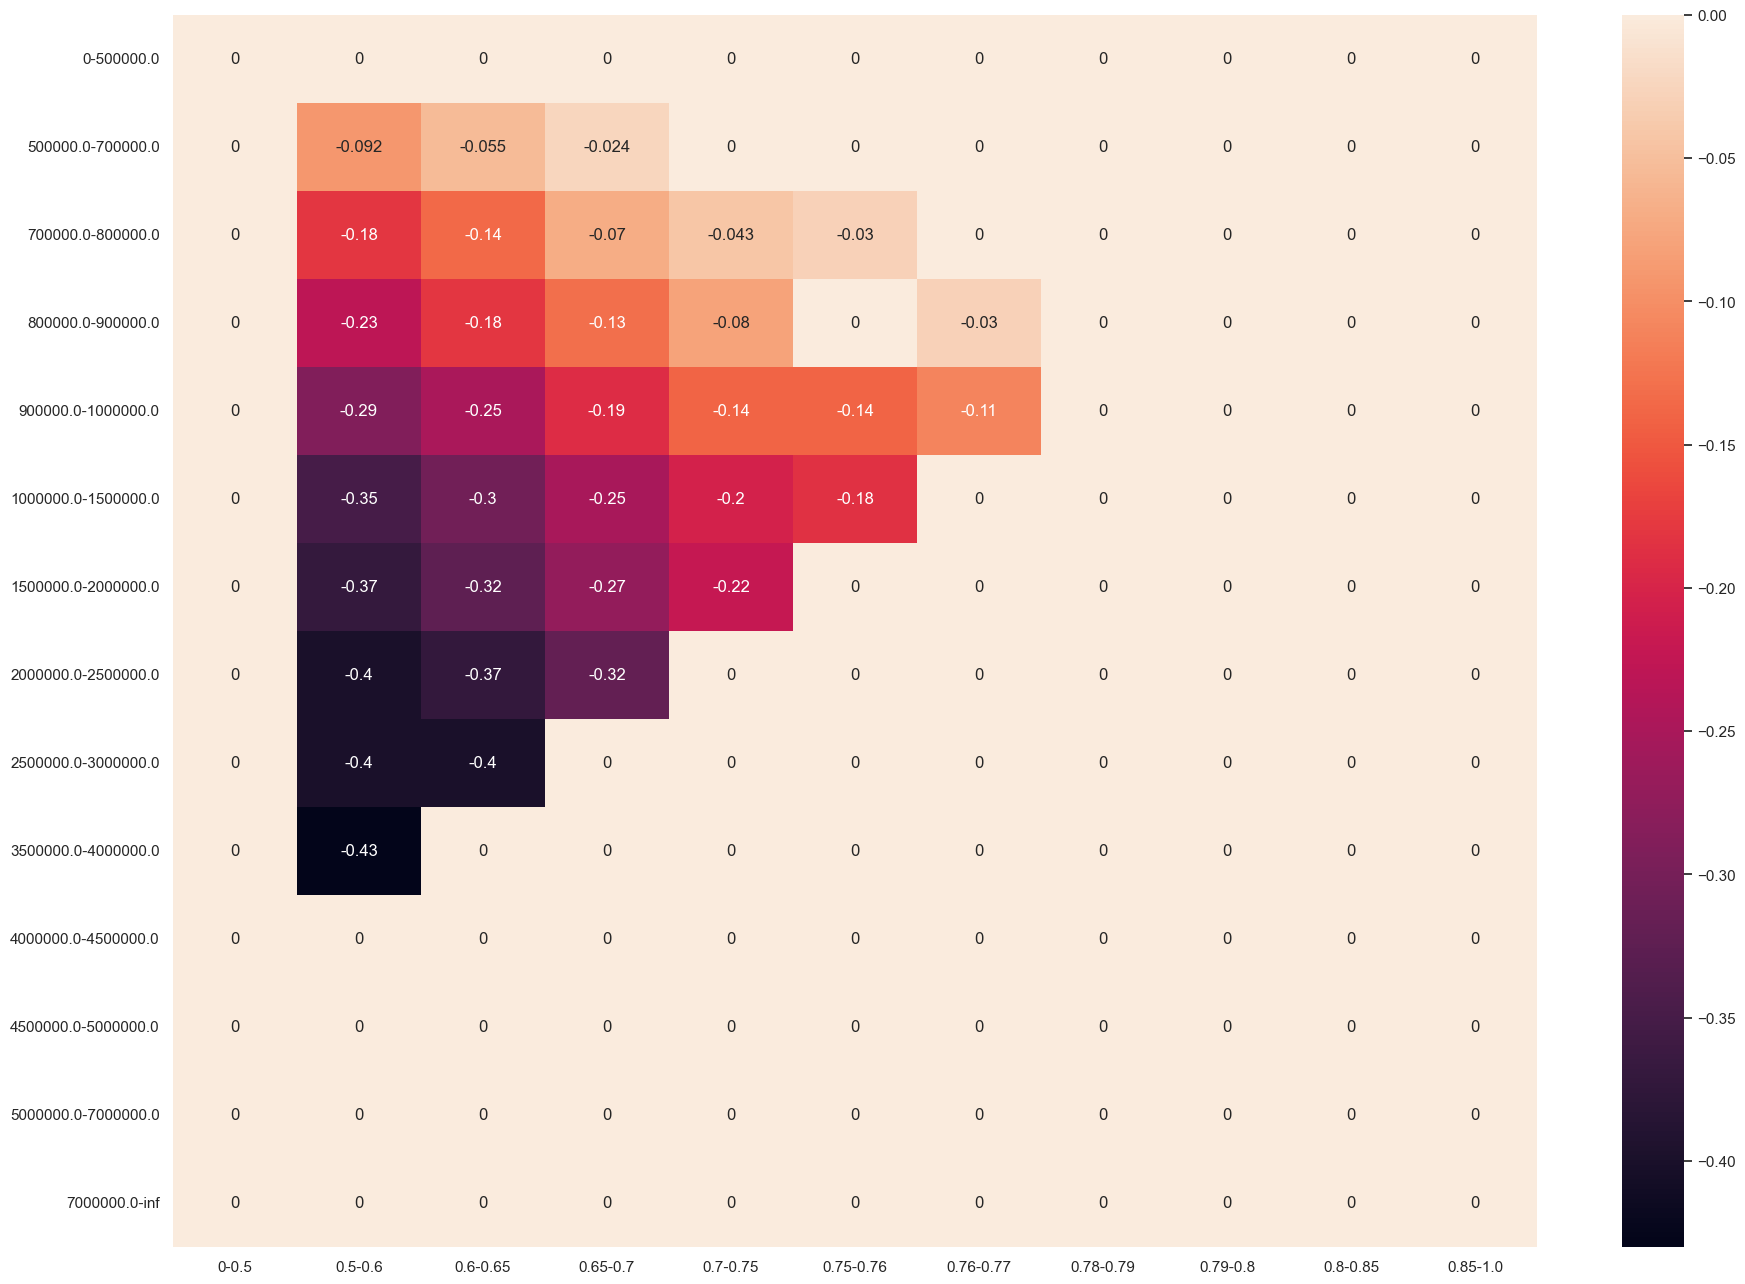

In [31]:
# output as pricing surface
plt.figure(figsize = (22,16))

filled_three_month_discount_df = three_month_discount_df.fillna(0)
sns.heatmap(filled_three_month_discount_df, annot=True)

In [29]:
three_month_df.groupby(["interest_rate", "loan_volume"])